<a href="https://colab.research.google.com/github/Kotya2001/X-rayLungsSegmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras
import numpy as np
import tensorflow as tf
from imutils import paths
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.integration_test.preprocessing_test_utils import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os

In [11]:
size = (256, 256)
def image_resize(img, size=(256, 256)):
    return cv2.resize(img,size )

In [3]:
width, height = 256, 256
input_shape = (width, height, 1)
epochs = 10
batch_size = 16

In [7]:
image_path = os.path.join('/content/drive/MyDrive/Segmentation/CXR_png')
mask_path = os.path.join('/content/drive/MyDrive/Segmentation/masks')

In [8]:
path_mask = list(paths.list_images("/content/drive/MyDrive/Segmentation/masks"))
path_image = list(paths.list_images("/content/drive/MyDrive/Segmentation/CXR_png"))

In [9]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [12]:
X = np.array([np.array(np.stack((image_resize(cv2.imread(os.path.join(image_path,filename.split("_mask")[0]+".png"),  0)),), 
                                axis=-1)) 
for filename in image_file_name])

In [13]:
y = np.array([np.array(np.stack(( cv2.resize(cv2.imread(filename, 0), (256,256)),), axis=-1)) for filename in path_mask])

In [15]:
X_flip = np.flip(X , axis = 2)
y_flip = np.flip(y, axis = 2)

X = np.append(X, X_flip, axis = 0)
y = np.append(y, y_flip, axis = 0)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True,
                                                      random_state=42)

In [17]:
X_train, X_valid = X_train / 255, X_valid / 255

y_train = (y_train/255. > 0.5).astype(int)
y_valid = (y_valid/255. > 0.5).astype(int)

In [18]:
inputs = layers.Input(shape=(256,256,1))

c0 = layers.Conv2D(64, activation='relu', kernel_size=(3,3), padding='same', name = 'C0')(inputs)
Drop = layers.Dropout(0.1)(c0)
c1 = layers.Conv2D(64, activation='relu', kernel_size=(3,3), padding='same', name = 'C1')(Drop)  
c2 = layers.MaxPool2D(pool_size=(2, 2), name = 'MaxPool_1')(c1)

c3 = layers.Conv2D(128, activation='relu', kernel_size=(3,3), padding='same', name = 'C3')(c2)
Drop = layers.Dropout(0.1)(c3)
c4 = layers.Conv2D(128, activation='relu', kernel_size=(3,3), padding='same', name = 'C4')(Drop) 
c5 = layers.MaxPool2D(pool_size=(2, 2), name = 'MaxPool_2')(c4)

c6 = layers.Conv2D(256, activation='relu', kernel_size=(3,3), padding='same', name = 'C6')(c5)
Drop = layers.Dropout(0.2)(c6)
c7 = layers.Conv2D(256, activation='relu', kernel_size=(3,3), padding='same', name = 'C7')(Drop)  
c8 = layers.MaxPool2D(pool_size=(2, 2), name = 'MaxPool_3')(c7) 

c9 = layers.Conv2D(512, activation='relu', kernel_size=(3,3),padding='same',  name = 'C9')(c8)
Drop = layers.Dropout(0.2)(c9)
c10 = layers.Conv2D(512, activation='relu', kernel_size=(3,3), padding='same', name = 'C10')(Drop)  
c11 = layers.MaxPool2D(pool_size=(2, 2), name = 'MaxPool_4')(c10)

c12 = layers.Conv2D(1024, activation='relu', kernel_size=(3,3), padding='same', name = 'C12')(c11)
Drop = layers.Dropout(0.3)(c12)
c13 = layers.Conv2D(1024, activation='relu', kernel_size=(3,3), padding='same', name = 'C13')(Drop)


t01 = layers.Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), padding='same', name = 'Transpose_T01')(c13)
concat01 = layers.concatenate([t01, c10], axis=3, name= 'Concat_1')

c14 = layers.Conv2D(512, activation='relu', kernel_size=(3,3), padding='same', name = 'C14')(concat01)
Drop = layers.Dropout(0.3)(c14)
c15 = layers.Conv2D(512, activation='relu', kernel_size=(3,3), padding='same', name = 'C15')(Drop)

t02 = layers.Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), padding='same', name = 'Transpose_T02')(c15)
concat02 = layers.concatenate([t02, c7], axis=3, name= 'Concat_2')

c16 = layers.Conv2D(256, activation='relu', kernel_size=(3,3), padding='same', name = 'C16')(concat02)
Drop = layers.Dropout(0.2)(c16)
c17 = layers.Conv2D(256, activation='relu', kernel_size=(3,3), padding='same', name = 'C17')(Drop)

t03 = layers.Conv2DTranspose(128, kernel_size=(2,2), strides=(2, 2), name = 'Transpose_T03')(c17)
concat03 = layers.concatenate([t03, c4], axis=3, name= 'Concat_3')

c18 = layers.Conv2D(128, activation='relu', kernel_size=(3,3), padding='same', name = 'C18')(concat03)
Drop = layers.Dropout(0.2)(c18)
c19 = layers.Conv2D(128, activation='relu', kernel_size=(3,3), padding='same', name = 'C19')(Drop)

t04 = layers.Conv2DTranspose(64, kernel_size=(2,2), strides=(2, 2), padding='same', name = 'Transpose_T04')(c19)
concat04 = layers.concatenate([t04, c1], axis=3, name= 'Concat_4')

c20 = layers.Conv2D(64, activation='relu', kernel_size=(3,3), name = 'C20', padding = 'same')(concat04)
Drop = layers.Dropout(0.1)(c20)
c21 = layers.Conv2D(64, activation='relu', kernel_size=(3,3), name = 'C21', padding = 'same')(Drop)

output = layers.Conv2D(1, activation='sigmoid', kernel_size=(1,1), name = 'O/P')(c21)

In [ ]:
model = keras.Model(inputs, output, name='UNet')
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.003), loss='binary_crossentropy',
              metrics = ['accuracy'])
callbacks = ModelCheckpoint('/content/drive/MyDrive/Работа/Unet', monitor='val_accuracy', save_best_only=True, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid),
          batch_size=batch_size, callbacks=callbacks)

Epoch 1/10
141/141 [==============================] - ETA: 0s - loss: 0.5297 - accuracy: 0.7382
Epoch 00001: val_accuracy improved from -inf to 0.74543, saving model to /content/drive/MyDrive/Работа/Unet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Работа/Unet/assets
141/141 [==============================] - 261s 2s/step - loss: 0.5297 - accuracy: 0.7382 - val_loss: 0.3696 - val_accuracy: 0.7454
Epoch 2/10
141/141 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8432
Epoch 00002: val_accuracy improved from 0.74543 to 0.90863, saving model to /content/drive/MyDrive/Работа/Unet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Работа/Unet/assets
141/141 [==============================] - 244s 2s/step - loss: 0.3382 - accuracy: 0.8432 - val_loss: 0.2386 - val_accuracy: 0.9086
Epoch 3/10
141/141 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9312
Epoch 00003: val_accuracy improved from 0.90863 to 0.94749, saving model to

Проверка модели

In [19]:
from tensorflow.keras.models import load_model


In [23]:
loaded_model = load_model('/content/drive/MyDrive/Segmentation/Unet')

In [25]:
test_paths = [i for i in os.listdir('/content/drive/MyDrive/Segmentation/test')]

In [36]:
dir = ['/content/drive/MyDrive/Segmentation/test/' + i for i in test_paths]

In [54]:
def get_segmentation(model, dir, number):
  image = np.array(np.stack((cv2.resize(cv2.imread(dir[number], 0),
                                              (256, 256)),), axis=-1))
  image = np.expand_dims(image, axis=0)

  image = image / 255.

  prediction = model.predict(image)

  return prediction[0, ..., 0]

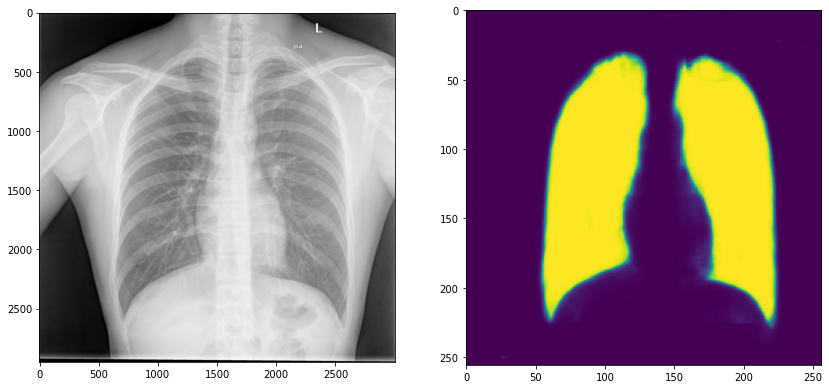

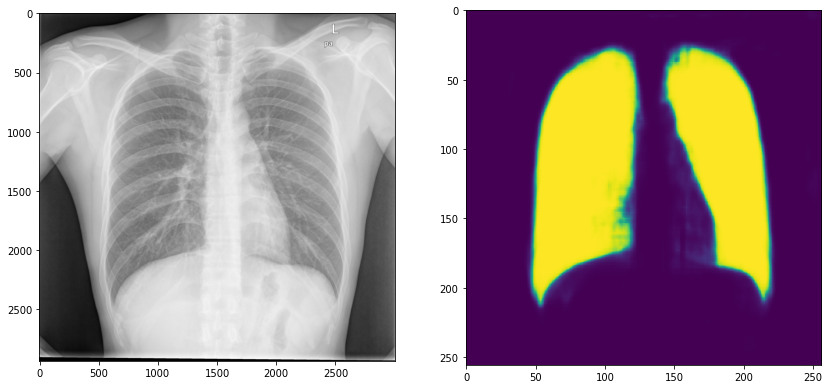

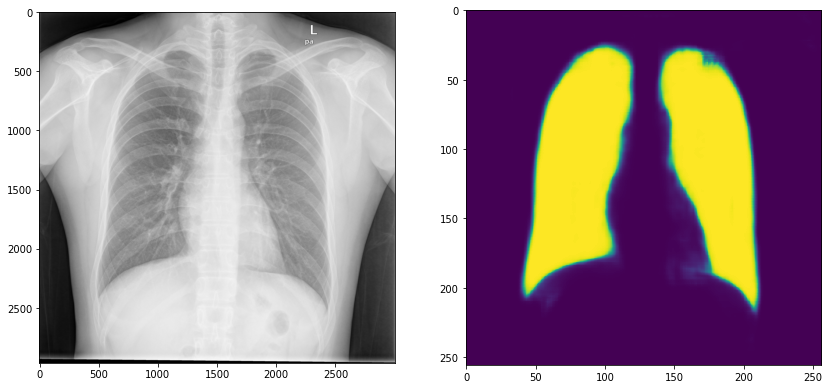

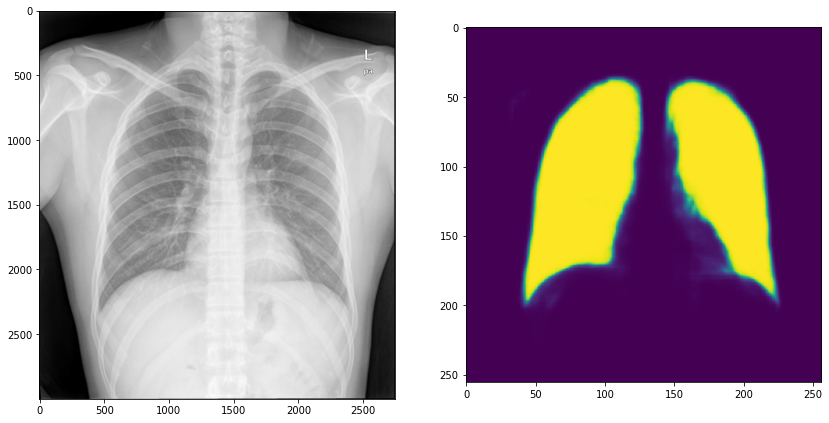

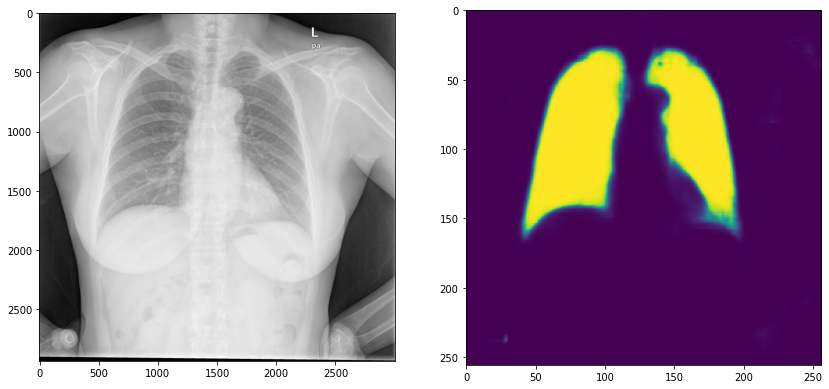

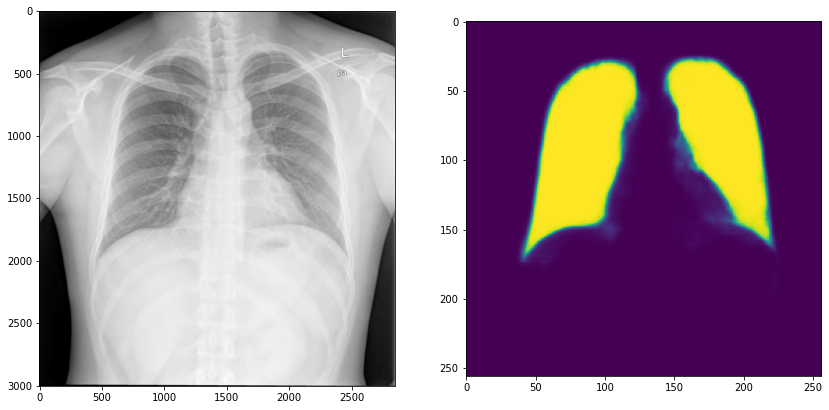

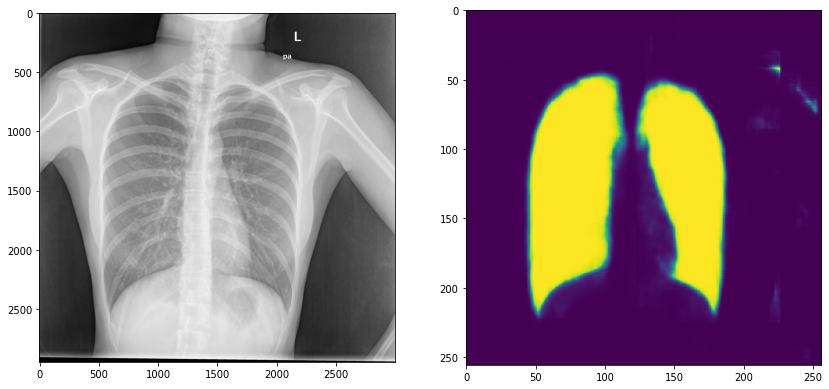

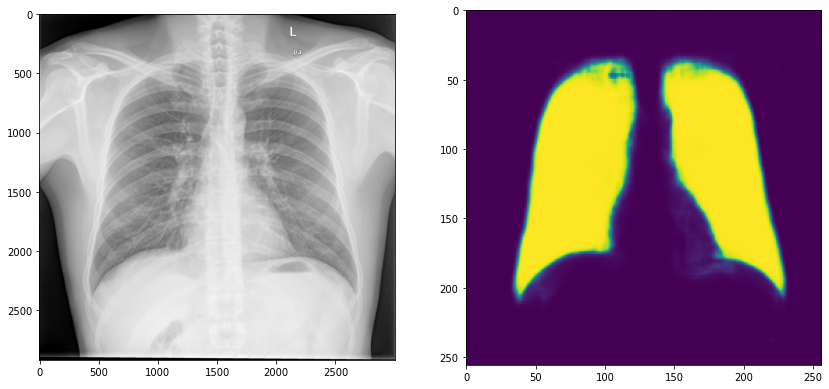

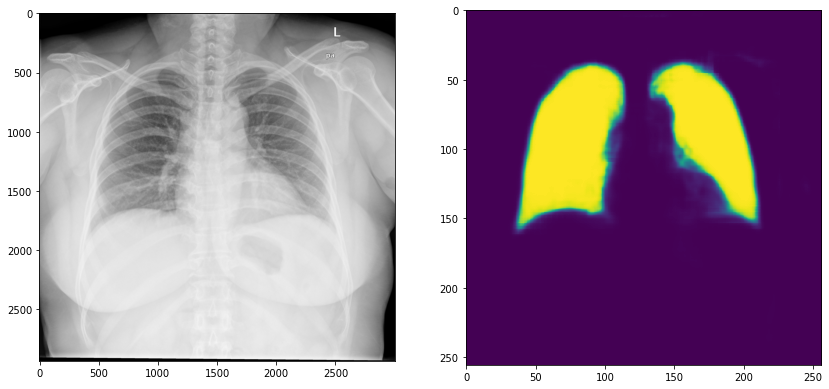

In [63]:
for i in range(len(dir)):
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))
  ax[0].imshow(cv2.imread(dir[i]))
  ax[1].imshow(get_segmentation(loaded_model, dir, i))

  if i > 7:
    break
